In [64]:
import pandas as pd
import os
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [12]:
path = os.getcwd()
temp = path.split('/')
temp.pop(-1)
temp.pop(-1)  # remove it before submission
path = '/'.join(temp)
filename = '/data_v_7_stc/meta/meta.txt'

### Read meta file

In [27]:
meta = pd.read_csv(path + filename, sep="\t", header=None)
meta.columns = ["filename", "where", "something", "length", "label"]
meta.head()

,filename,where,something,length,label
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background


In [83]:
print(meta["label"].unique(), meta["label"].nunique())
# meta["label"].isnull().sum()
meta["label"][meta["label"] == 'ring'].count()
# door = 3416
# ring = 713
# speech = 276

['background' 'bags' 'door' 'keyboard' 'knocking_door' 'ring' 'speech'
 'tool'] 8


713

### Open file

In [84]:
fs, data = wavfile.read(path + '/data_v_7_stc/audio/' + meta["filename"].loc[1])

<function matplotlib.pyplot.show(*args, **kw)>

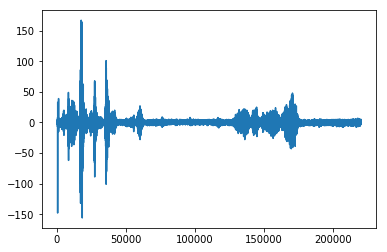

In [85]:
plt.plot(data)
plt.show

In [67]:
print(type(data))


numpy.ndarray